# Import Libs

In [1]:
import numpy as np

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm

    ##read CSV file and create data set. Also split the data based on date 2017-08-16 as this is our test data-set.

In [2]:
print("Reading trend CSV and test CSV")
Flav_sales_train_orig = pd.read_csv(
    "/Users/sunilsavanur/Documents/Kaggles/Flavorita_store_prediction/train_sales.csv", 
    usecols=['id','store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    parse_dates=["date"])

Flav_sales_train = Flav_sales_train_orig.copy()
le = LabelEncoder()  # from sklearn.preprocessing
Flav_sales_train['family'] = le.fit_transform(Flav_sales_train['family'])

Flav_sales_train['date'] = Flav_sales_train_orig.date.dt.to_period('D')
#Flav_sales_train = Flav_sales_train.set_index(['store_nbr', 'family', 'date']).sort_index() # family_sales =

print("Flav_sales_train index -> ",Flav_sales_train.index.name)
print("Flav_sales_train shape -> ",Flav_sales_train.shape)
#display(Flav_sales_train.info())
#display(Flav_sales_train)

df_cut = Flav_sales_train.loc[(Flav_sales_train['date'] >= '2017-07-01') & (Flav_sales_train['date'] <= '2017-08-31')]
#display(df_cut)

df_train = df_cut.loc[(df_cut['date'] <= '2017-08-15')] #& (df_cut['id'] <= B)]
df_test = df_cut.loc[(df_cut['date'] >= '2017-08-16') & (df_cut['date'] <= '2017-08-31')]

print("df_train  df_train  df_train info ---> ", df_train.info())
display(df_train)

Reading trend CSV and test CSV
Flav_sales_train index ->  None
Flav_sales_train shape ->  (3009798, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 81972 entries, 2899314 to 2981285
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   date         81972 non-null  period[D]
 1   store_nbr    81972 non-null  int64    
 2   family       81972 non-null  int64    
 3   id           81972 non-null  int64    
 4   sales        81972 non-null  float64  
 5   onpromotion  81972 non-null  int64    
dtypes: float64(1), int64(4), period[D](1)
memory usage: 4.4 MB
df_train  df_train  df_train info --->  None


,date,store_nbr,family,id,sales,onpromotion
2899314,2017-07-01,1,0,2918916,7.000,0
2899315,2017-07-01,1,1,2918917,0.000,0
2899316,2017-07-01,1,2,2918918,7.000,1
2899317,2017-07-01,1,3,2918919,2596.000,27
2899318,2017-07-01,1,4,2918920,0.000,0
...,...,...,...,...,...,...
2981281,2017-08-15,54,28,3000751,59.619,0
2981282,2017-08-15,54,29,3000752,94.000,0
2981283,2017-08-15,54,30,3000753,915.371,76
2981284,2017-08-15,54,31,3000754,0.000,0


In [3]:
# Calculate covariance between x and y
def covariance(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    covar = 0.0
    for i in range(len(x)):
        covar += (x[i] - mean_x) * (y[i] - mean_y)
    return covar/len(x)



    ##plot correlation digram

/var/folders/sp/lq50ck6s67x_cp6fl8zyy_hr0000gn/T/ipykernel_1916/3571091581.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True)


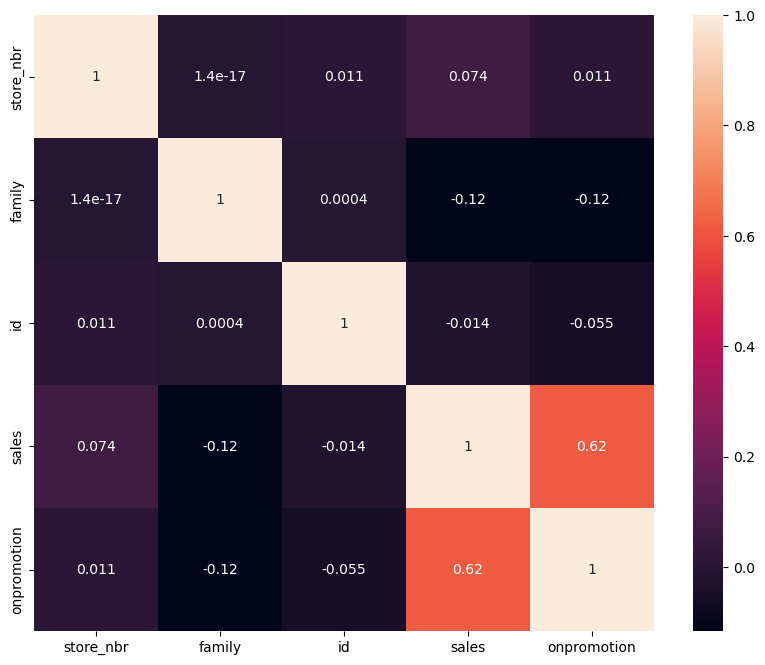

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(), annot=True)
plt.show()


    ## It seems that only 'sales' and 'onpromotion' variables are correlated. While store_nbr, family and id are least related.

    ## prepare y, X. Here y is target dataframe with sales as target value while X is  onpromotion feature. Both dataframe hvae 'date' as index. The we go on adding various columns to X. The use deterministicprocess of order 2, this will give 'trend' and 'trend_squared'. Add these two columns to X. Later as sin / cos pairs for 'sales', 'onpromotion'. Also split the data based on date 2017-08-16.

In [5]:
y = df_train[['date','sales']].set_index(['date'])
X = df_train[['date','onpromotion']].set_index(['date'])

dp = DeterministicProcess(index=X.index, order=2)
X_1 = dp.in_sample()
print("dp X_1",X_1)

X['trend'] = X_1['trend']
X['trend_sq'] = X_1['trend_squared']

X['sin_1'] = np.sin(y['sales'])
X['cos_1'] = np.cos(y['sales'])
X['sin_2'] = np.sin(X['onpromotion'])
X['cos_2'] = np.cos(X['onpromotion'])
#X['sin_3'] = np.sin(X['onpromotion'] + y['sales'])
#X['cos_3'] = np.cos(X['onpromotion'] + y['sales'])

y_test = df_test[['date','sales']].set_index(['date'])
X_test = df_test[['date','onpromotion']].set_index(['date'])
#X = sm.add_constant(X)

display(X)

dp X_1               trend  trend_squared
date                              
2017-07-01      1.0   1.000000e+00
2017-07-01      2.0   4.000000e+00
2017-07-01      3.0   9.000000e+00
2017-07-01      4.0   1.600000e+01
2017-07-01      5.0   2.500000e+01
...             ...            ...
2017-08-15  81968.0   6.718753e+09
2017-08-15  81969.0   6.718917e+09
2017-08-15  81970.0   6.719081e+09
2017-08-15  81971.0   6.719245e+09
2017-08-15  81972.0   6.719409e+09

[81972 rows x 2 columns]


,onpromotion,trend,trend_sq,sin_1,cos_1,sin_2,cos_2
date,,,,,,,
2017-07-01,0,1.0,1.000000e+00,0.656987,0.753902,0.000000,1.000000
2017-07-01,0,2.0,4.000000e+00,0.000000,1.000000,0.000000,1.000000
2017-07-01,1,3.0,9.000000e+00,0.656987,0.753902,0.841471,0.540302
2017-07-01,27,4.0,1.600000e+01,0.864657,0.502362,0.956376,-0.292139
2017-07-01,0,5.0,2.500000e+01,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...
2017-08-15,0,81968.0,6.718753e+09,0.071200,-0.997462,0.000000,1.000000
2017-08-15,0,81969.0,6.718917e+09,-0.245252,0.969459,0.000000,1.000000
2017-08-15,76,81970.0,6.719081e+09,-0.919787,-0.392418,0.566108,0.824331


In [6]:

covar_xy = covariance(X['onpromotion'], y['sales'])
print(f'Cov(X,Y): {covar_xy}')

mean_x = np.mean(X['onpromotion'])
mean_y = np.mean(y['sales'])

var_x = np.var(X['onpromotion'])
var_y = np.var(y['sales'])


print('x stats: mean= %.3f   variance= %.3f' % (mean_x, var_x))
print('y stats: mean= %.3f   variance= %.3f' % (mean_y, var_y))

b1 = covar_xy / var_x
b0 = mean_y - b1 * mean_x

print(f'Coefficents:\n b0: {b0}  b1: {b1} ')


# Taking the values from the dataframe and sorting only X for the ease of plotting line later on
x_onp = X['onpromotion'].values.copy()
# x.sort()
print(f'x: {x_onp}')

# Predicting the new data based on calculated coeffiecents. 
y_hat = b0 + b1 * x_onp
print(f'\n\ny_hat: {y_hat}')

y = y['sales'].values
print(f'\n\ny: {y}')

mse = mean_squared_error(y, y_hat)
r_squared = r2_score(y, y_hat)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

residuals = y - y_hat
print("residuals",residuals)

std_err_resid = np.std(residuals)
print("---- std_err_resid----",std_err_resid)


Cov(X,Y): 14372.74118377404
x stats: mean= 6.946   variance= 312.324
y stats: mean= 481.198   variance= 1737874.998
Coefficents:
 b0: 161.53691735696884  b1: 46.01865157202899 
x: [ 0  0  1 ... 76  0  0]


y_hat: [ 161.53691736  161.53691736  207.55556893 ... 3658.95443683  161.53691736
  161.53691736]


y: [  7.      0.      7.    ... 915.371   0.      3.   ]
Mean_Squared_Error : 1076460.829497279
r_square_value : 0.38058788426607704
residuals [ -154.53691736  -161.53691736  -200.55556893 ... -2743.58343683
  -161.53691736  -158.53691736]
---- std_err_resid---- 1037.526303038761


    ## Do linear regression. It appears that our sales and onpromotion are 39% related, hence our prediction has large MSE value.

In [24]:
lr_model = LinearRegression().fit(X,y)

y_pred_lr = lr_model.predict(X)

print("y_pred_lr ...",y_pred_lr)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred_lr,squared=True))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred_lr))

y_pred_lr ... [  50.08716583   55.00873347  142.65912375 ... 3495.22772496  140.7294059
  182.52691356]
Mean squared error: 1061716.84
Coefficient of determination: 0.39


,X,y,y_pred_lr
0,2017-07-01,7,50
1,2017-07-01,0,55
2,2017-07-01,7,142
3,2017-07-01,2596,1427
4,2017-07-01,0,55
...,...,...,...
81967,2017-08-15,59,183
81968,2017-08-15,94,145
81969,2017-08-15,915,3495
81970,2017-08-15,0,140


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


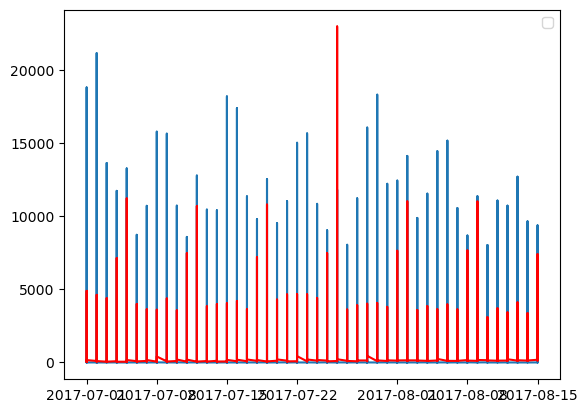

In [25]:
dfX = pd.DataFrame({'X':X.index.to_timestamp()})
dfX['y']= pd.Series(y).astype(int)
dfX['y_pred_lr']= pd.Series(y_pred_lr).astype(int)
display(dfX)

plt.plot(dfX.X, dfX.y)
plt.plot(dfX.X, dfX.y_pred_lr, color='red')
plt.legend()
plt.show()